# TERM DEPOSIT SUBSCRIPTION PREDICTION

## Exploratory Data Analysis

### a. Importation of neccessary libraries

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb

sns.set(style='whitegrid')
%matplotlib inline

### b. Loading data

In [107]:
bank_data = pd.read_csv('../data_files/bank-full.csv', sep=';')

### c. Overview of data

In [108]:
bank_data.head()

bank_data.info()

bank_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


### d. Check for missing values

In [109]:
bank_data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### e. Renaming and encoding target column 

In [110]:
bank_data.rename(columns={'y': 'Subscription'}, inplace=True)
bank_data['Subscription'] = bank_data['Subscription'].map({'yes': 1, 'no': 0})
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Subscription
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


## f. Checking features with one value

In [111]:
for column in bank_data.columns:
    print(column,bank_data[column].nunique())

age 77
job 12
marital 3
education 4
default 2
balance 7168
housing 2
loan 2
contact 3
day 31
month 12
duration 1573
campaign 48
pdays 559
previous 41
poutcome 4
Subscription 2


### g. Defining categorical and numeric columns

In [112]:
categorical_columns = bank_data.select_dtypes(include='object').columns.tolist()
numerical_columns = bank_data.select_dtypes(include=np.number).columns.drop('Subscription').tolist()

In [113]:
print("Categorical columns = " , categorical_columns)
print("")
print("Numerical columns = " , numerical_columns)

Categorical columns =  ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Numerical columns =  ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [114]:
# categorical columns content check
for column in bank_data.select_dtypes(include='object').columns:
    print(column)
    print(bank_data[column].unique())
    print("")

job
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

marital
['married' 'single' 'divorced']

education
['tertiary' 'secondary' 'unknown' 'primary']

default
['no' 'yes']

housing
['yes' 'no']

loan
['no' 'yes']

contact
['unknown' 'cellular' 'telephone']

month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

poutcome
['unknown' 'failure' 'other' 'success']



### h. Class distribution of target
      target is the Subscrption column

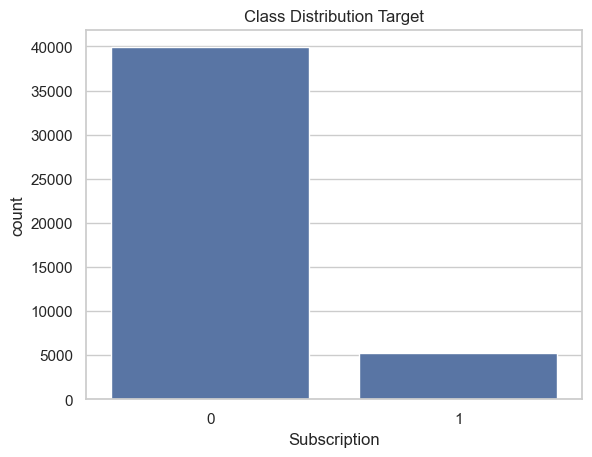

In [115]:
sns.countplot(x='Subscription', data=bank_data)
plt.title('Class Distribution Target')
plt.show()

## i. Categorical columns count check

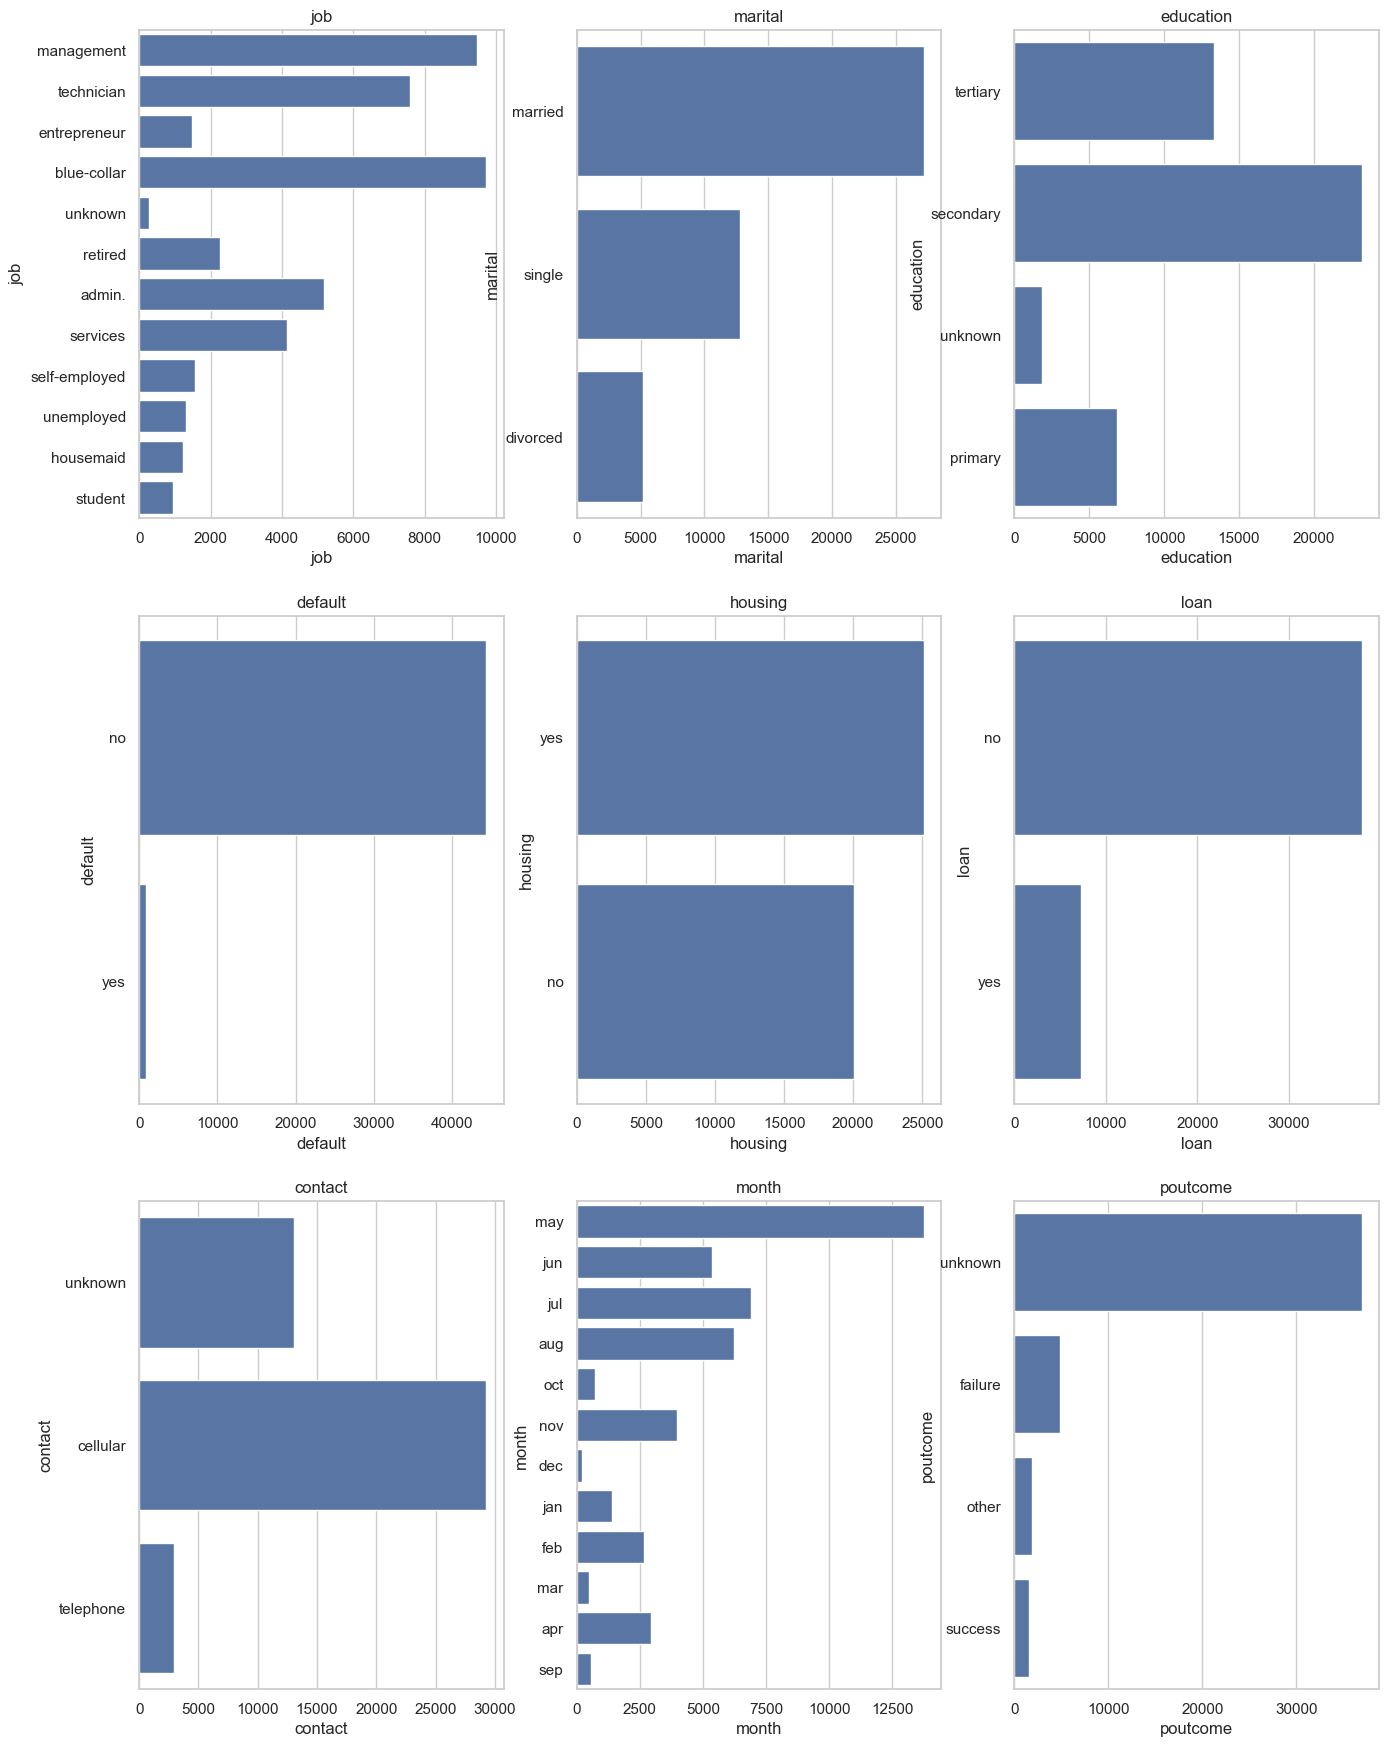

In [116]:
plt.figure(figsize=(16,90))
plotnumber =1
for feature in categorical_columns:
    ax = plt.subplot(12,3,plotnumber)
    sns.countplot(y=feature,data=bank_data)
    plt.xlabel(feature)
    plt.title(feature)
    plotnumber+=1
plt.show()

## j. Relationship between categorical variable and target variable

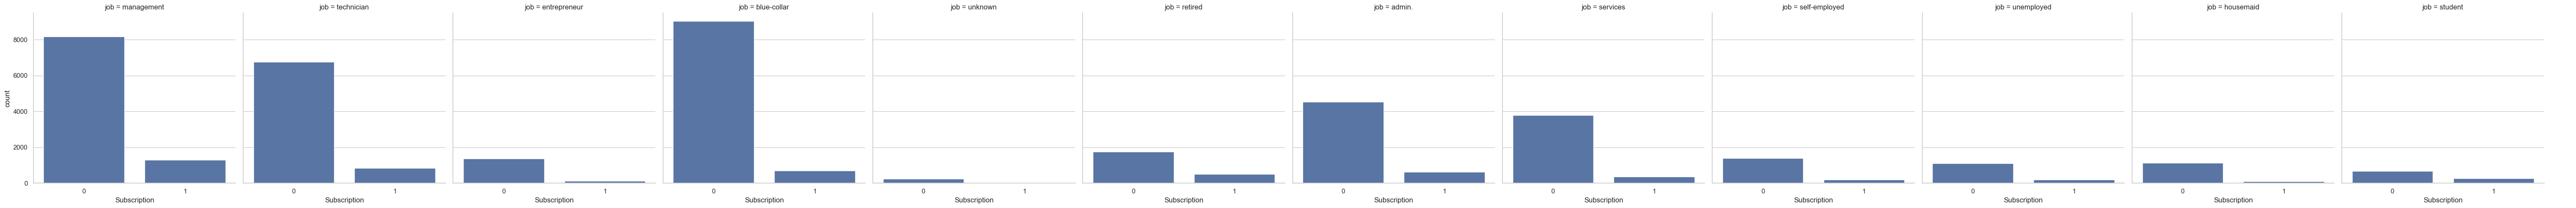

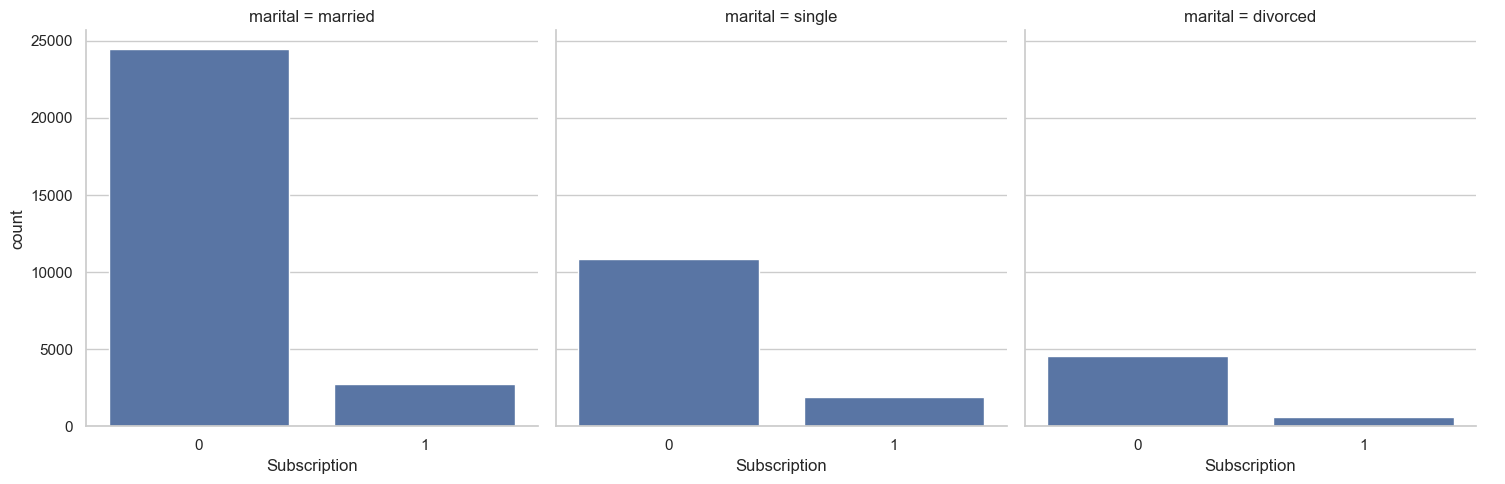

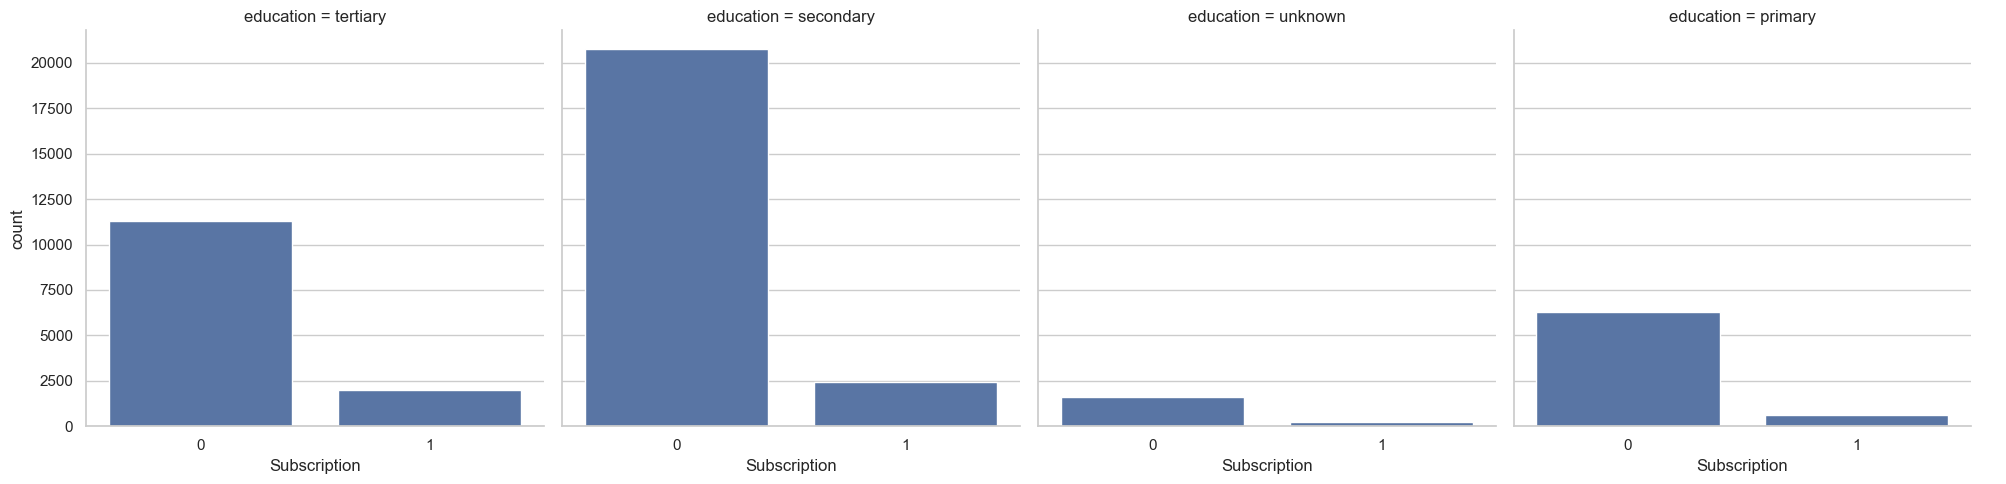

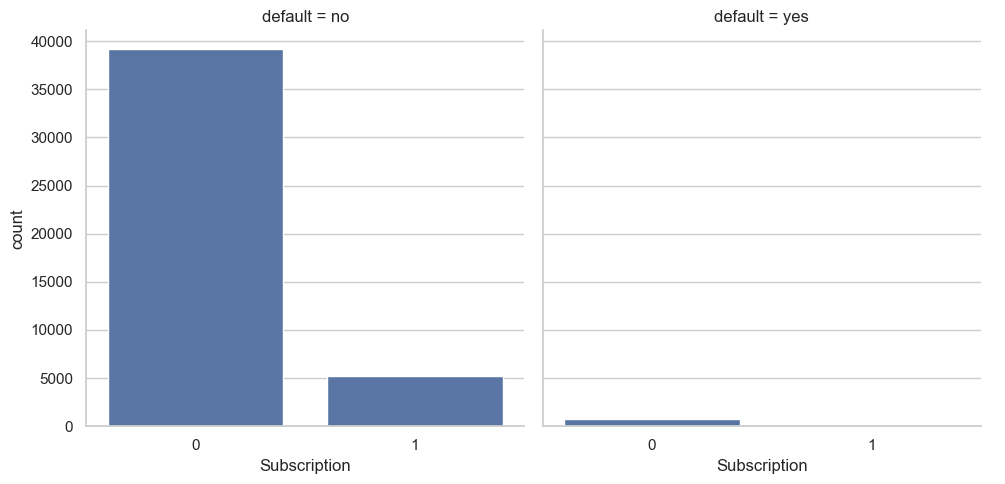

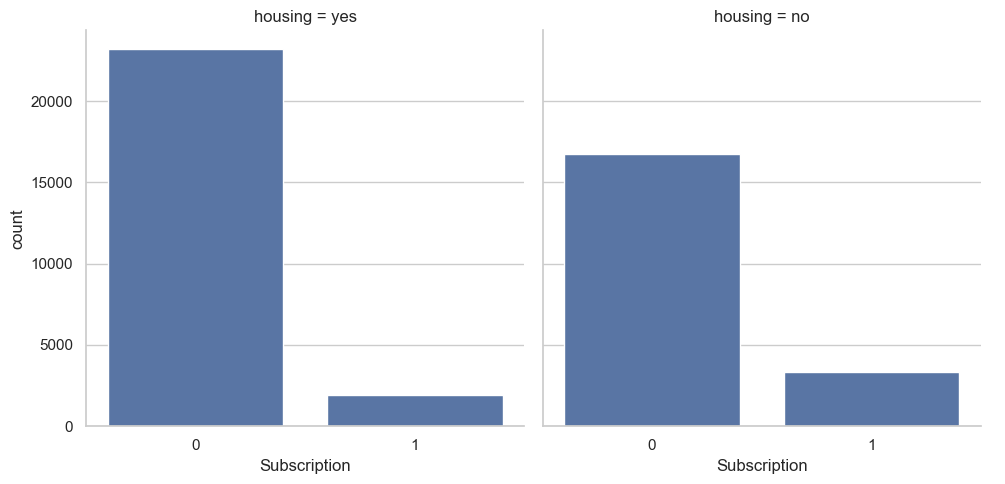

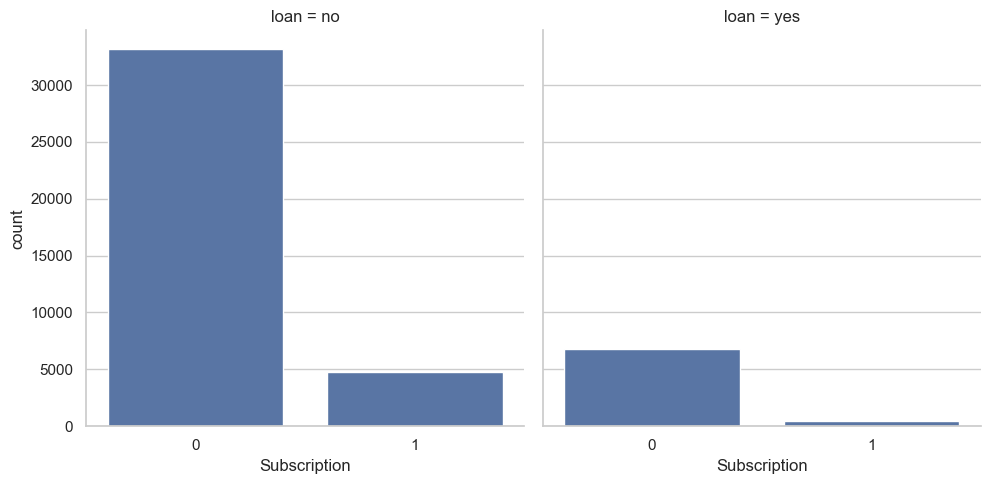

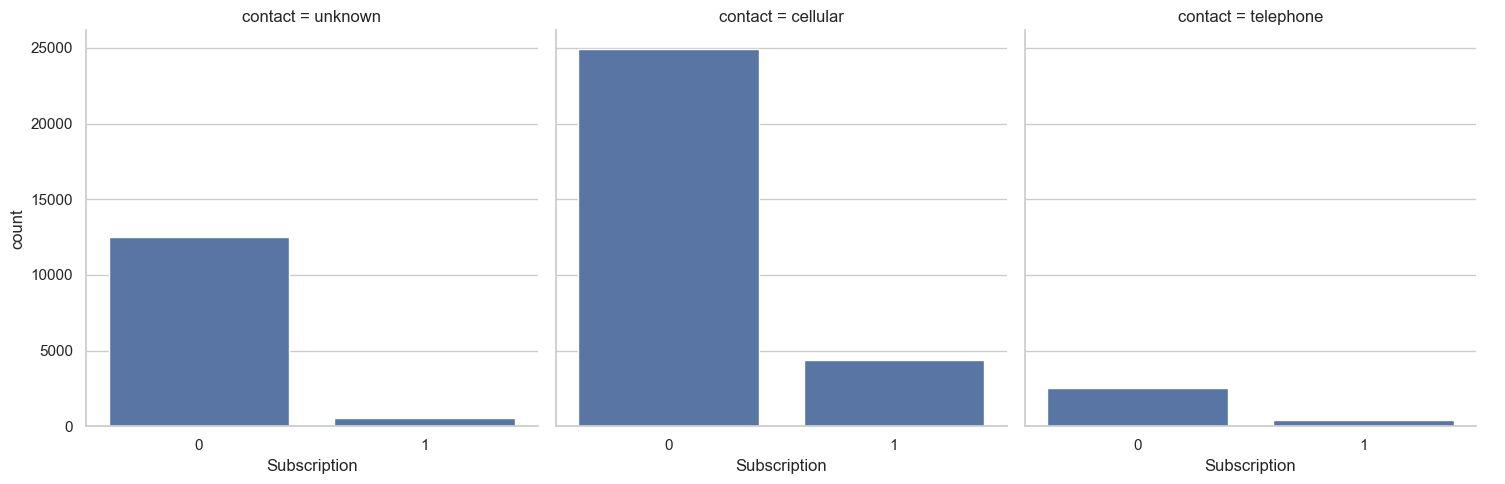

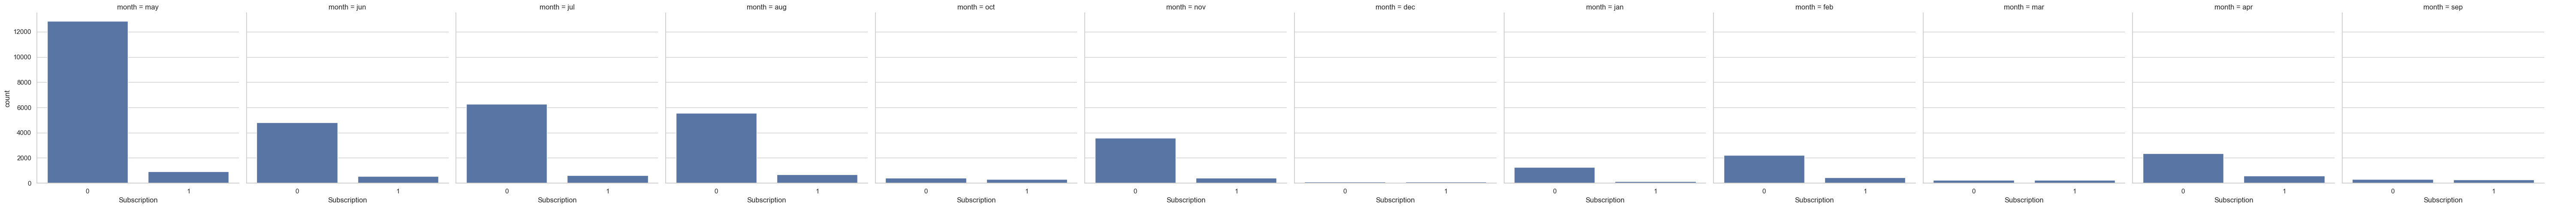

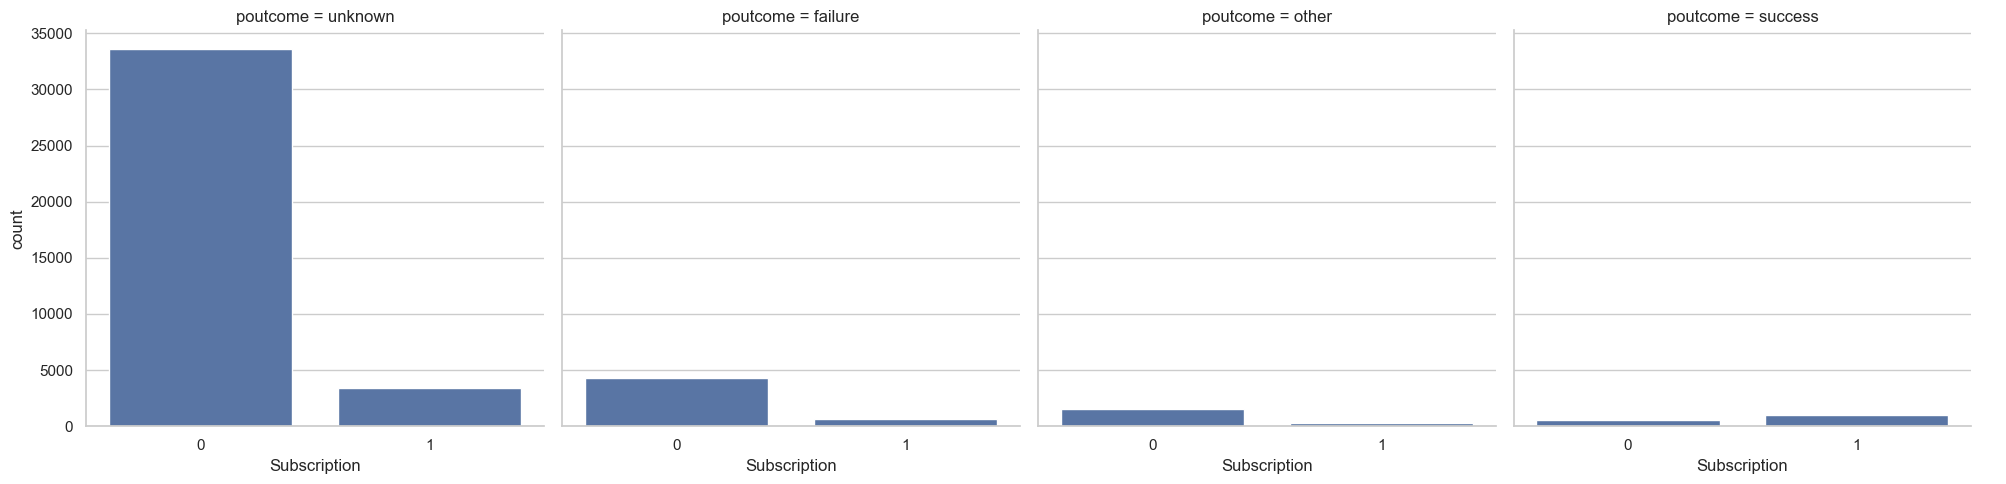

In [117]:
for feature in categorical_columns:
    sns.catplot(x='Subscription', col=feature, kind='count', data= bank_data)
plt.show()

## k. Target label split over categorical features and counts

In [118]:
for feature in categorical_columns:
    print(bank_data.groupby(['Subscription',feature]).size())

Subscription  job          
0             admin.           4540
              blue-collar      9024
              entrepreneur     1364
              housemaid        1131
              management       8157
              retired          1748
              self-employed    1392
              services         3785
              student           669
              technician       6757
              unemployed       1101
              unknown           254
1             admin.            631
              blue-collar       708
              entrepreneur      123
              housemaid         109
              management       1301
              retired           516
              self-employed     187
              services          369
              student           269
              technician        840
              unemployed        202
              unknown            34
dtype: int64
Subscription  marital 
0             divorced     4585
              married     24459
        

### f. Correlation between numerical features 


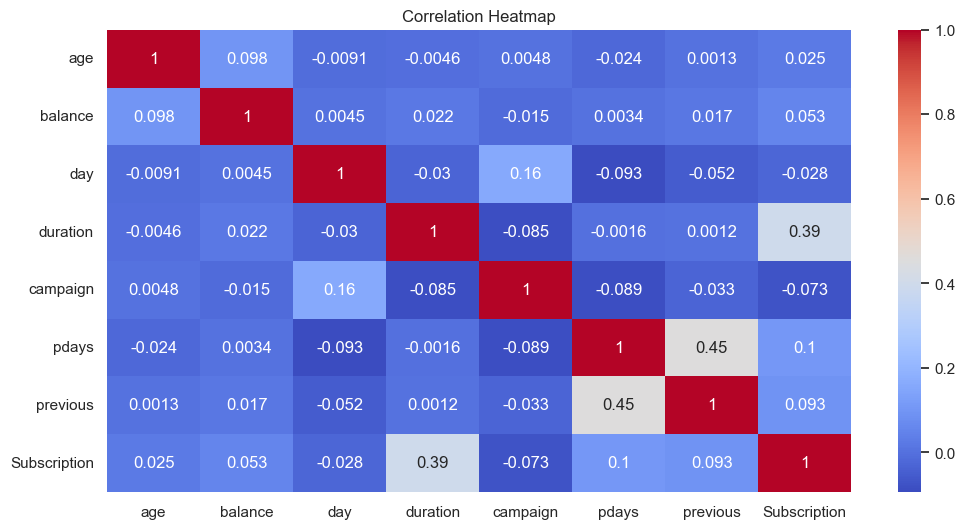

In [119]:
numeric_data = bank_data.select_dtypes(include=[np.number])
cor_mat = numeric_data.corr()
plt.figure(figsize=(12, 6))
sns.heatmap(cor_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Feature Engineering

### a. Spliting data into testing data and traning data

In [120]:
X = bank_data.drop('Subscription', axis=1)
y = bank_data['Subscription']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### b. Preprocessing pipeline

In [121]:
preprocessor = ColumnTransformer([
    ('numerical', StandardScaler(), numerical_columns),
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
])


### c. Fit-transform training set

In [122]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

### c. Combining X and y for balancing

In [123]:

train_data = pd.DataFrame(X_train_processed.toarray() if hasattr(X_train_processed, 'toarray') else X_train_processed)
train_data['Subscription'] = y_train.reset_index(drop=True)

# Upsample minority class
majority = train_data[train_data.Subscription == 0]
minority = train_data[train_data.Subscription == 1]

minority_upsampled = resample(minority, replace=True, n_samples=len(majority), random_state=42)
upsampled = pd.concat([majority, minority_upsampled])

X_train_bal = upsampled.drop('Subscription', axis=1)
y_train_bal = upsampled['Subscription']

## Model Training

In [ ]:
# XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_bal, y_train_bal)

## Model Evaluation

In [125]:
# Prediction and evaluation
sub_pred = xgb_model.predict(X_test_processed)
print("Accuracy:", accuracy_score(y_test, sub_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, sub_pred))
print("\nClassification Report:\n", classification_report(y_test, sub_pred))

Accuracy: 0.8723874820302997

Confusion Matrix:
 [[7040  945]
 [ 209  849]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.88      0.92      7985
           1       0.47      0.80      0.60      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.84      0.76      9043
weighted avg       0.91      0.87      0.89      9043

